# Fairness, Accountability, Transparency and Ethics Course (FATE)


## Universitat Pompeu Fabra (UPF)
### 20/21

### Author: David Solans (david.solans@upf.edu)

**Legend** <br>
In this notebook we use:    
<div class="alert alert-block col-md-7 alert-info">To recall information from the theory classes and other tips</div>
<div class="alert alert-block col-md-7 alert-warning">To point important things that should not be 
   forgotten</div> 
<div class="alert alert-block col-md-7 alert-success">To indicate tasks to be done by students</div>

# Session 03

# 2. Algorithmic Fairness with Python

In this second notebook, we will study the concept of Algorithmic Fairness.


The purpose of this notebook is to give you a set of examples to show what type of Fairness assessments can be done with the knowledge you already have.

<div class="col-md-10 col-md-offset-1 text-center">
    <img src="https://miro.medium.com/max/700/0*THacHbKnCewphbnu.jpg"></img>
    <p class="col-md-10 col-md-offset-1 ">Illustration of disparate impact — in this diagram the data distribution of two groups is very different, which leads to differences in the output of the algorithm without any explicit association of the groups. Source: <a href="https://www.kdnuggets.com/2018/05/machine-learning-breaking-bad-bias-fairness.html">KdNuggets</a>
</p>
</div>

###  Libraries used in this notebook
You will need to install: **numpy**, **pandas**, **matplotlib**, and **sklearn**.

In [24]:
## Required statements
import pandas as pd
import numpy as np

# Sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Plotting requirements
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 2.1 Algorithmic Fairness motivation. 

Example from: Zliobaite, I and Custers, B: Using sensitive data may be necessary for avoiding discrimination in data-driven decision models (2016)

### 2.1.1 Color-awareness is enough? Can unfairness be avoided by just not considering sensitive data?

#### Toy example: why sensitive data is necessary?
Suposse that the underlying mechanism how salaries are decided is: 
$$ salary = 1000 + 100 * education - 500 * ethnicity$$

Where education is number of years after graduation and ethnicity is 1 for inmigrants and 0 for natives.

This means that we implicitly have two sub-population groups, as given by the ethnicity attribute that has values in the set [0,1]. 

In [8]:
## We define years of experience and ethnicity for 10 individuals
toy_data_base = [
                 [1,1],
                 [1,0],
                 [2,1],
                 [6,0],
                 [3,1],
                 [7,0],
                 [4,1],
                 [9,0],
                 [10,1],
                 [10,0]
                 
                ]

In [9]:
## Function used to generate data
def toy_salary_generator(num_years, is_inmigrant):
    return 1000 + 100 * num_years - 500*int(is_inmigrant)

In [10]:
## Calculating the salary for each individual inside toy_data_base
toy_data = [[v[0], v[1], toy_salary_generator(v[0], v[1])] for v in toy_data_base]

In [11]:
## Formatting data in a pandas dataframe
df = pd.DataFrame(columns=["education", "ethnicity", "salary"], data=toy_data)
df.head()

,education,ethnicity,salary
0,1,1,600
1,1,0,1100
2,2,1,700
3,6,0,1600
4,3,1,800


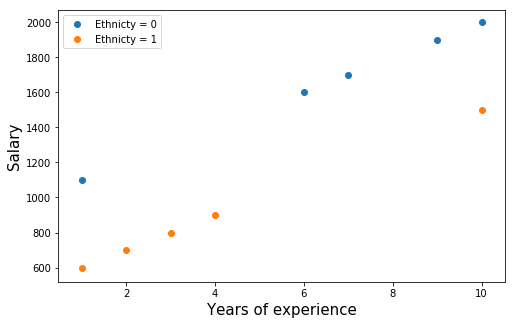

In [12]:
## Visualization of the results
f = plt.figure(figsize=[8,5])

df1 = df[df['ethnicity'] == 1]
df2 = df[df['ethnicity'] != 1]

X1 = df1['education'].values.reshape(-1, 1)
Y1 = df1['salary'].values

X2 = df2['education'].values.reshape(-1, 1)
Y2 = df2['salary'].values

plt.scatter(X2, Y2, label="Ethnicty = 0")
plt.scatter(X1, Y1, label="Ethnicty = 1")


plt.xlabel("Years of experience", fontsize=15)
plt.ylabel("Salary", fontsize=15)

plt.legend()
plt.show()


<br>
<div class="alert alert-block alert-info col-md-12">
<b>Oberservations: <b>
    <br>
    <ul>
        <li>Data is well balanced (half of the samples have *ethnicity* = 1).</li>
        <li>Most of highest salaries are given to *ethnicity* = 0.</li>
        <li>In the following, we will refer to ethnicity = 0 as the privileged group and ethnicity = 1 as disadvantaged or protected group.</li>
    </ul>
<br>


### 2.1.2 How can we build here a model that predicts salary?

This is a regression problem. 

We will use a simple Linear Regression to illustrate and reason about the implications of using all the information available, use color-awareness (not using the race as input attribute) or other options

#### 2.1.2.1 Option 1: Remove sensitive attribute (Ethnicity)

Mean squared error: 53402.24
   - MAE protected group: 213.61
   - MAE privileged group: 213.61 

   - MAE lower salary group: 211.37
   - MAE higher salary group: 215.85 

pred_salary = 601.636520 + 127.993109 * education


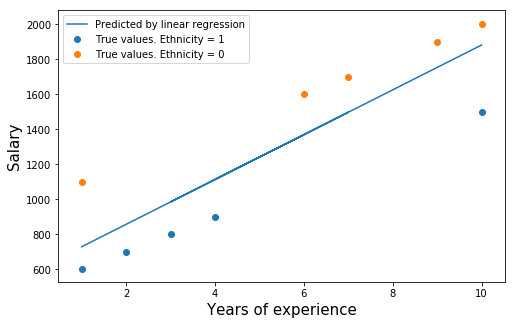

In [25]:
## Training a linear regression model solely based on education to predict the salary

X = df['education'].values.reshape(-1, 1)
Y = df['salary'].values

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

# Predict salary for the same individuals
predicted_salary = regr.predict(X)

# Plotting results
f = plt.figure(figsize=[8,5])

plt.scatter(X1, Y1, label = "True values. Ethnicity = 1")
plt.scatter(X2, Y2, label = "True values. Ethnicity = 0")
plt.plot(X, predicted_salary, label = "Predicted by linear regression")

print("Mean squared error: %.2f" % mean_squared_error(Y, predicted_salary))


print("   - MAE protected group: %.2f" % mean_absolute_error(Y1, regr.predict(X1)))
print("   - MAE privileged group: %.2f \n" % mean_absolute_error(Y2, regr.predict(X2)))

print("   - MAE lower salary group: %.2f" % mean_absolute_error(Y[Y<1400], predicted_salary[Y<1400]))
print("   - MAE higher salary group: %.2f \n" % mean_absolute_error(Y[Y>1400], predicted_salary[Y>1400]))


# The coefficients of the regressor
b_0 = regr.intercept_ #Independent term
b_1 = tuple(regr.coef_) # Coefficient

print("pred_salary = %f + %f * education" % ((b_0, )+ b_1))
plt.xlabel("Years of experience", fontsize=15)
plt.ylabel("Salary", fontsize=15)

plt.legend()
plt.show()


<br>
<div class="alert alert-block alert-info col-md-12">
<b>Oberservations: <b>
    <br>
    <ul>
        <li>The fitted model punishes people with low education more than necessary.</li>
        <li>Also, it rewards people with high education more than deserved </li>
        <li>It is by itself already incorrect reflection of the underlying process, and would
make incorrect recommendations, if used as a recommender system for salaries.</li></ul>
<br>



####  2.1.2.2 Option 2: Use sensitive attribute

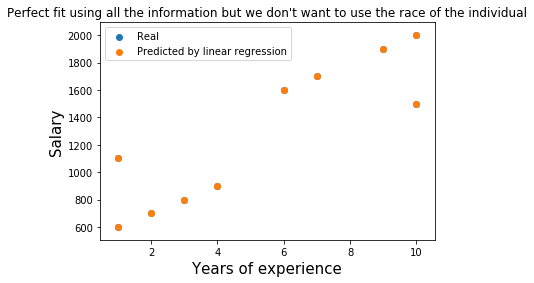

Mean squared error: 0.00 

pred_salary_model = 1000.000000 + 100.000000 * education + -500.000000 * ethnicity


In [19]:
# Predicting salary by also considering the protected column 'ethnicity'

education= df['education'].values
ethnicity = df['ethnicity'].values

X=[[education[i], int(ethnicity[i])]  for i in range(len(education))]


Y = df['salary'].values


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

# Plot outputs
plt.scatter(education, Y, label = "Real")

predicted_salary = regr.predict(X)



plt.scatter(education, predicted_salary, label = "Predicted by linear regression")
plt.xlabel("Years of experience", fontsize=15)
plt.ylabel("Salary", fontsize=15)

plt.title("Perfect fit using all the information but we don't want to use the race of the individual")
plt.legend()
plt.show()

print("Mean squared error: %.2f \n" % mean_squared_error(Y, predicted_salary))


# The coefficients of the regressor
b_0 = regr.intercept_ #Independent term
b_1 = tuple(regr.coef_) # Coefficients

print("pred_salary_model = %f + %f * education + %f * ethnicity" % ((b_0, )+ b_1))


<br>
<div class="alert alert-block alert-info col-md-12">
<b>Oberservations: <b>
    <br>
    <ul>
        <li>Using all the information, we obtain a perfect fit, but we don't want to use a model that explicitly depends on the race!</li></ul>
<br>



####  2.1.2.3 Option 3:  Consider sensitive data and then, remove its coefficient. We obtain a constant error for all the individuals, so there is no discrimination.**

Mean squared error: 0.00
   - MSE protected group: 250000.00
   - MSE privileged group: 0.00 



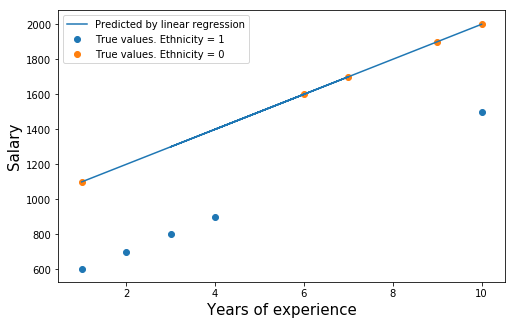

In [9]:
def predict_with_fair_regressor(_X):
    _pred = []
    for v in _X:
        _pred.append(1000 + 100*v)
    return np.array(_pred)


X = df['education'].values.reshape(-1, 1)
Y = df['salary'].values

df1 = df[df['ethnicity'] == 1]
df2 = df[df['ethnicity'] != 1]

X1 = df1['education'].values.reshape(-1, 1)
Y1 = df1['salary'].values

X2 = df2['education'].values.reshape(-1, 1)
Y2 = df2['salary'].values


fair_Y1 = predict_with_fair_regressor(X1)
fair_Y2 = predict_with_fair_regressor(X2)
fair_Y = predict_with_fair_regressor(X)




# Plotting results
f = plt.figure(figsize=[8,5])

plt.scatter(X1, Y1, label = "True values. Ethnicity = 1")
plt.scatter(X2, Y2, label = "True values. Ethnicity = 0")
plt.plot(X, fair_Y, label = "Predicted by linear regression")
plt.xlabel("Years of experience", fontsize=15)
plt.ylabel("Salary", fontsize=15)
print("Mean squared error: %.2f" % mean_squared_error(Y, predicted_salary))


print("   - MSE protected group: %.2f" % mean_squared_error(Y1, predict_with_fair_regressor(X1)))
print("   - MSE privileged group: %.2f \n" % mean_squared_error(Y2, predict_with_fair_regressor(X2)))


plt.legend()
plt.show()




<br>
<div class="alert alert-block alert-info col-md-12">
<b>Oberservations: <b>
    <br>
    <ul>
        <li>It equalizes salaries at the top bound</li>
        <li>Also, it satisfies color-awareness since it does not use the enthnicity as input attribute</li>
    </ul>

</div>


<div class="alert alert-block alert-success">Check the provided examples and answer the following questions. 
    <br>
    Please, elaborate your questions so we can use your answers to generate a debate in class:</div>
<br>

## Questions 1 (1 point):
    1. Which option do you think is the more fair?
    2. Which option would you prefer if you were a company having to pay the salaries?
    3. Which option would you prefer if you were an individual with ethnicity=1?
    4. Do you think ML engineers typically consider this ideas?
    
Please, remember to elaborate your answers

**Your answers**:
1. ...
2. ...
3. ...
4. ...

## 2.2 Algoritmic fairness in the real world: Adult Census Income

This data was extracted from the [1994 Census bureau database](https://www.census.gov/en.html) by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics).

The prediction task is to determine whether a person makes over $50K a year.


In [28]:
## Loading the dataset using pandas
columns_names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

df = pd.read_csv("../Data/adult.data", names=columns_names)

df = df.dropna()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 2.2.1 Exploratory Analysis

We begin the analysis of the data by analyzing the distributions among different attributes

We split the population in two groups: 
- Those who make more than 50K (*privileged*)
- Those who make less or equal than 50K (*disadvantaged* / *protected*)


Base on that grouping, we want to understand what are the distributions of such inviduals according to age, workclass, education level, gender and/or race.



#### 2.2.1.1 Age

age: the age of an individual Integer greater than 0

Text(0, 0.5, 'Age / Income')

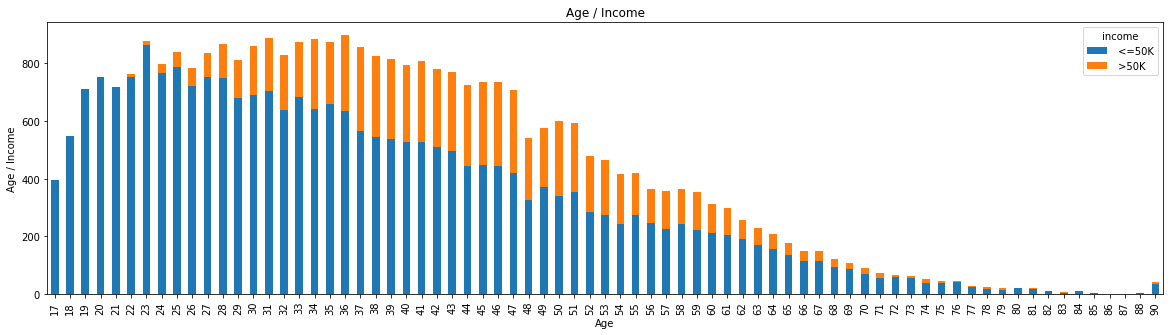

In [11]:
pd.crosstab(df.age,df.income).plot(kind='bar', figsize=(20,5), stacked=True)
plt.title('Age / Income')
plt.xlabel('Age')
plt.ylabel('Age / Income')

## Example of interpretation: 
**(no need to answer here)**

<div class="alert alert-block alert-success">Interpret what you see in the age plot above. Do inviduals of both groups have similar demographics?.</div>

**Your answer**:
* Older people have the chance to earn more than the younger ones
* Teens earn less than 50k
* From an age where you have most likely graduated from college, you can start to earn over 50k

#### 2.2.1.2 Workclass
workclass: a general term to represent the employment status of an individual Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

Text(0, 0.5, 'Workclass / Income')

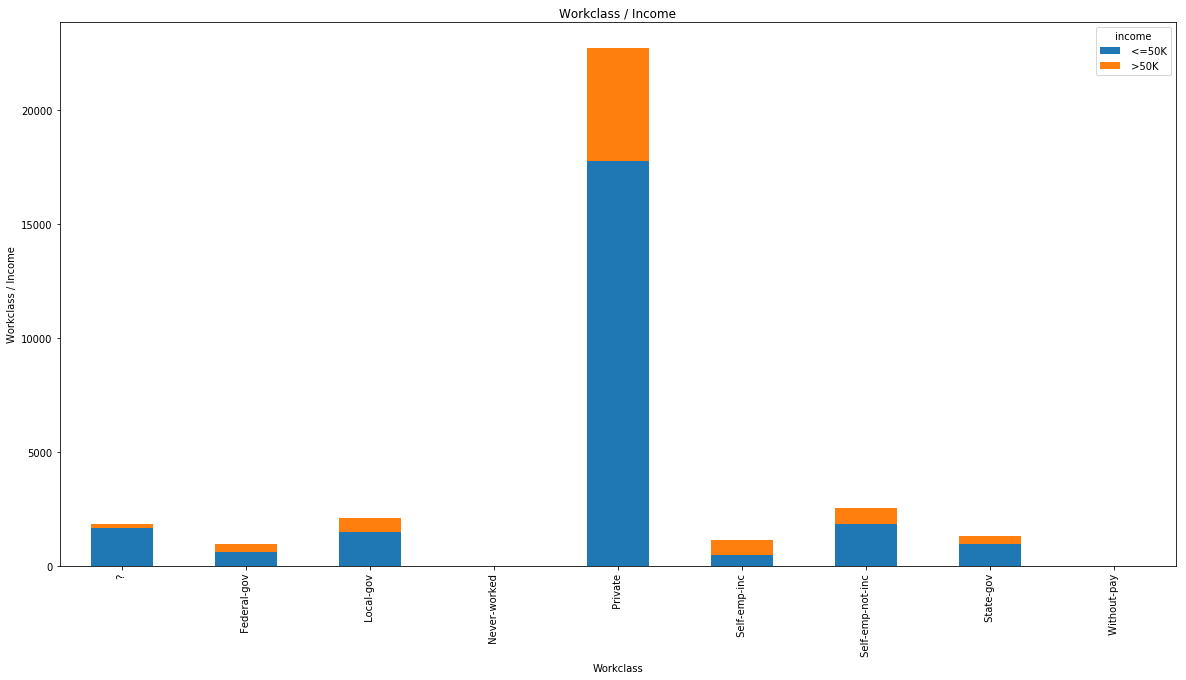

In [12]:
pd.crosstab(df.workclass,df.income).plot(kind='bar', figsize=(20,10), stacked=True)
plt.title('Workclass / Income')
plt.xlabel('Workclass')
plt.ylabel('Workclass / Income')

In [13]:
df.groupby('workclass').income.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

workclass          income
 ?                  <=50K     89.6%
                    >50K      10.4%
 Federal-gov        <=50K     61.4%
                    >50K      38.6%
 Local-gov          <=50K     70.5%
                    >50K      29.5%
 Never-worked       <=50K    100.0%
 Private            <=50K     78.1%
                    >50K      21.9%
 Self-emp-inc       >50K      55.7%
                    <=50K     44.3%
 Self-emp-not-inc   <=50K     71.5%
                    >50K      28.5%
 State-gov          <=50K     72.8%
                    >50K      27.2%
 Without-pay        <=50K    100.0%
Name: income, dtype: object

## Question 2(0.5 point):

<div class="alert alert-block alert-success">Interpret what you see in the work class plot above. Do inviduals of both groups have similar demographics?. </div>

<div class="alert alert-block alert-warning">To answer this and the following questions, you should describe general findings. Two-Three bullet points is enough. If you need some extra coding, feel free to add it above the answer cell.</div>

<div class="alert alert-block alert-info">To interpret the work-class results, you can focus on:
    <ul>
        <li>Public vs private sector</li>
        <li>Which are the groups with bigger chances or getting high salary. </li>
    </ul>

In [35]:
## Optional: If you need some more code, add it here

**Your answer**:
* ...

#### 2.2.1.3 Education level

education: the highest level of education achieved by an individual. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

Text(0, 0.5, 'Education / Income')

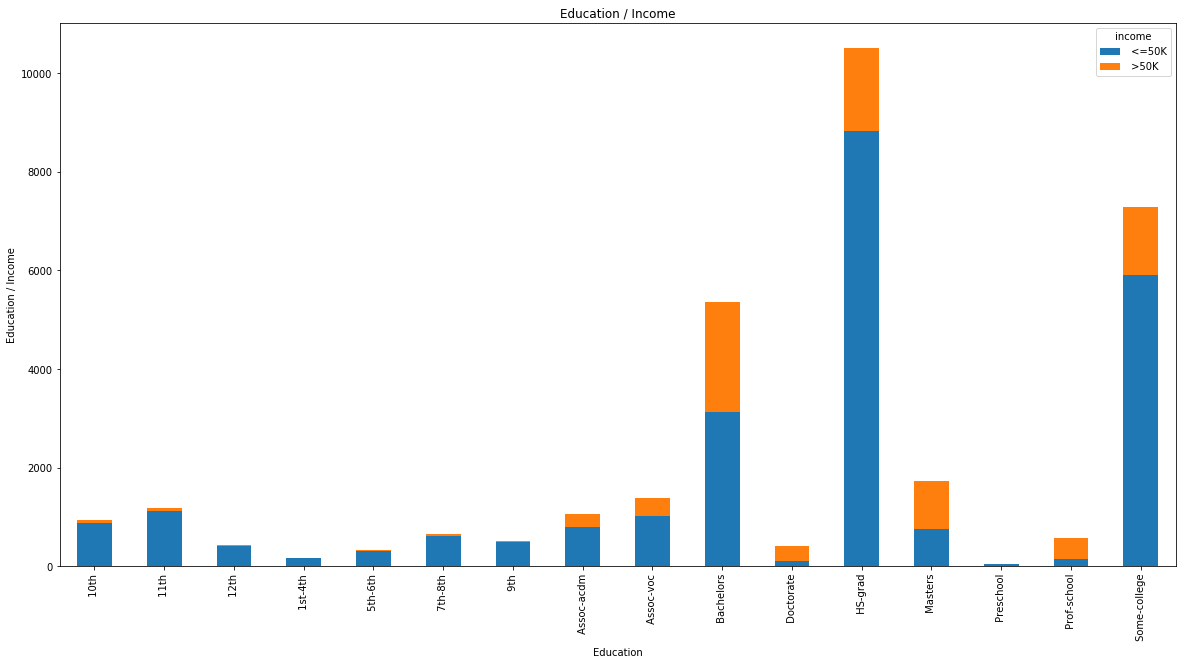

In [14]:
pd.crosstab(df.education,df.income).plot(kind='bar', figsize=(20,10), stacked=True)
plt.title('Education / Income')
plt.xlabel('Education')
plt.ylabel('Education / Income')

## Question 3(0.5 point):
<div class="alert alert-block alert-success">Interpret what you see in the education level plot above. Do inviduals of both groups have similar demographics?.</div>



In [34]:
## Optional: If you need some more code, add it here

**Your answer**:
* ...

#### 2.2.1.4 Gender

Text(0, 0.5, 'Sex / Income')

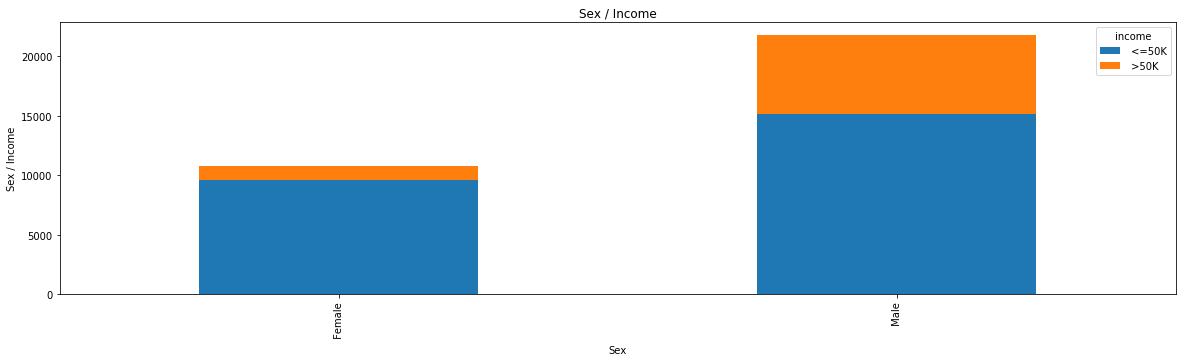

In [15]:
pd.crosstab(df.sex,df.income).plot(kind='bar', figsize=(20,5), stacked=True)
plt.title('Sex / Income')
plt.xlabel('Sex')
plt.ylabel('Sex / Income')

## Question 4(0.5 point):
<div class="alert alert-block alert-success">Interpret what you see in the gender plot above. Do inviduals of both groups have similar demographics?.</div>



In [ ]:
## Optional: If you need some more code, add it here

**Your answer**:
* ...

#### 2.2.1.5 Race

Text(0, 0.5, 'Race / Income')

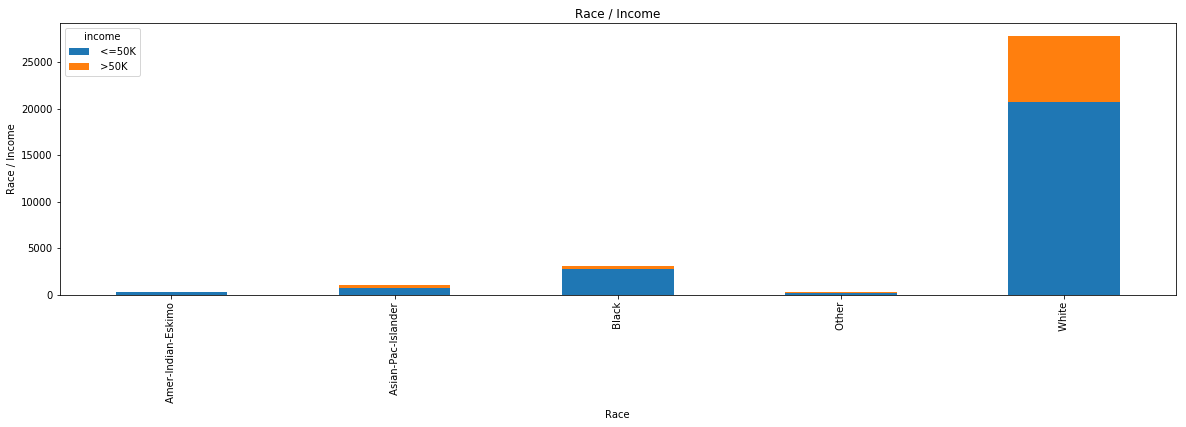

In [17]:
pd.crosstab(df.race,df.income).plot(kind='bar', figsize=(20,5), stacked=True)
plt.title('Race / Income')
plt.xlabel('Race')
plt.ylabel('Race / Income')

## Question 5(0.5 point):
<div class="alert alert-block alert-success">Interpret what you see in the race plot above. Do inviduals of both groups have similar demographics?.</div>


In [36]:
## Optional: If you need some more code, add it here

**Your answer**:
* ...

## 2.2.2 Training a model to predict income based on this dataset

Now, we will use Sklearn to build a model that predicts the income

#### 1. Transforming data for SKLEARN

In [18]:
## Shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)


X = pd.get_dummies(df.drop(columns=["income"]))

le = LabelEncoder()
y = le.fit_transform(df["income"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=19)
X_train.shape, X_test.shape

((21164, 108), (11397, 108))

In [19]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

In [20]:
print(" {} in train: {}".format(le.inverse_transform([0])[0], len(y_train[y_train==1]) / len(y_train)))
print(" {} in test: {}".format(le.inverse_transform([0])[0], len(y_test[y_test==1]) / len(y_test)))

  <=50K in train: 0.24045549045549044
  <=50K in test: 0.2414670527331754


In [21]:
# define the reference model
model = RandomForestClassifier(n_estimators=100)
model_name = "Random Forest"

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


### Does the model work well? Assessing model performance

In [22]:
accuracy_score(y_test, y_pred)

0.8538211810125471

## Question 6 (2 point):
<div class="alert alert-block alert-success">Based on what we have seen, create a function that plots (using matplotlib) the observed performance of this system for the protected and disadvantaged groups.
    
For this, you can use one of the protected attributes seen above (age, race, workclass...).

First, you should run an analysis based on model performance where can use different performance metrics such as: accuracy, roc_auc, precision, recall...

<ul>
    <li>Accuracy</li>
    <li>Area under the ROC curve</li>
    <li>Precision</li>
    <li> Any other thay you think applies to this use case</li>
</ul>


Then, you should do a second analysis, to see where does the model commit more errors. For that you can use metrics such as:
<ul>
    <li>False Positive Rate (FPR)</li>
    <li>False Negative Rate (FNR)</li>
    <li>or any other that you think applies to this use case.</li>
</ul>


<br>
After, write a dissertation on your opinions on your findings.

</div>

In [39]:
## Your model performance analysis here

In [38]:
## Your model error analysis here

**Your opinion here:**

<br>
<br>
<br>
<br>


# Session 04 

## 2.3 Using recidivism data exploration (SAVRY)

This Python Notebook is based in a notebook created by [ChaTo](http://chato.cl/research/) on January 2019 for educational purposes. 


It corresponds to a set of 850 juvenile offenders in Catalonia who were evaluated in 2010 using **SAVRY**, a structured risk assessment tool. The data on recidivism indicates if the same people committed a new offence in 2013-2015.


This is a sub-set of a dataset obtained by the *Centre d'Estudis Jurídics i Formació Especialitzada* of the Catalan government and released in 2017. The data was downloaded from [CEJFE / Generalitat de Catalunya](http://cejfe.gencat.cat/en/recerca/cataleg/crono/2017/reincidencia-jj/) and prepared by Marzieh Karimihaghighi and Carlos Castillo.


### 2.3.1 About the data

Do not use the data in this directory for research, as it is just a sub-set of attributes. Instead, use the [original dataset](http://cejfe.gencat.cat/en/recerca/cataleg/crono/2017/reincidencia-jj/) and cite the following publication:

```
@misc{cejfe_2017_savry,
 title={La reincid\`{e}ncia en la just\'{i}cia de menors},
 author={Marta Blanch and Manel Capdevila and Marta Ferrer and Berta Framis and \'{U}rsula Ruiz and Judit Mora and Ares Batlle and Berta L\'{o}pez},
 year={2017},
 howpublished={CEJFE},
 url={http://cejfe.gencat.cat/en/recerca/cataleg/crono/2017/reincidencia-jj/}
}
```

### 2.3.2 Mapping of variables to English

A codebook is available at the above-cited URL. The following is the mapping from English variables in this dataset (a subset of the variables in CEJFE's study) to the original variable names in Catalan.

| Variable in English | Original variable in Catalan |
|---------------------|------------------------------|
|	gender	|	V1_sexe	|
|	nationality	|	V2_Foreigner	|
|	main_crime_age	|	V8_edat_fet	|
|	criminal_records	|	V12_nombre_ante_agrupat	|
|	main_crime_category	|	V15_fet_agrupat	|
|	main_crime_is_violent	|	V16_fet_violencia	|
|	risk01_previous_violence	|	V65_@1_violencia_previa	|
|	risk02_history_nonviolent_offences	|	V66_@2_historia_delictes_no_violents	|
|	risk03_early_violence_before_14	|	V67_@3_inici_precoç_violencia	|
|	risk04_past_intervention_fail	|	V68_@4_fracas_intervencions_anteriors	|
|	risk05_self_harm_suicide_attempts	|	V69_@5_intents_autolesio_suicidi_anteriors	|
|	risk06_violence_at_home	|	V70_@6_exposicio_violencia_llar	|
|	risk07_childhood_mistreatment	|	V71_@7_historia_mHighracte_infantil	|
|	risk08_criminal_parent_caregiver	|	V72_@8_delinquencia_pares	|
|	risk09_early_separation_parents	|	V73_@9_separacio_precoç_pares	|
|	risk10_poor_school_achievement	|	V74_@10_Low_rendiment_escola	|
|	risk11_delinquency_peer_group	|	V75_@11_delinquencia_grup_iguals	|
|	risk12_rejection_peer_group	|	V76_@12_rebuig_grup_iguals	|
|	risk13_poor_stress_coping	|	V77_@13_estrés_incapacitat_enfrontar_dificultats	|
|	risk14_poor_parental_skills_parents	|	V78_@14_escassa_habilitat_pares_educar	|
|	risk15_lack_of_personal_social_support	|	V79_@15_manca_suport_personal_social	|
|	risk16_marginalized_environment	|	V80_@16_entorn_marginal	|
|	risk17_negative_attitudes	|	V81_@17_actitud_negatives	|
|	risk18_risk_taker_impulsive	|	V82_@18_assumpcio_riscos_impulsivitat	|
|	risk19_drug_abuse	|	V83_@19_problemes_consum_toxics	|
|	risk20_anger_management_issues	|	V84_@20_problemes_maneig_enuig	|
|	risk21_low_empaty	|	V85_@21_Low_nivell_empatia_remordiment	|
|	risk22_attention_deficit	|	V86_@22_problemes_concentracio_hiperactivitat	|
|	risk23_poor_compliance_interventions	|	V87_@23_Lowa_colaboracio_intervencions	|
|	risk24_low_commitment_school	|	V88_@24_Low_compromis_escolar_laboral	|
|	protective01_prosocial_activities	|	V89_@P1_impicacio_prosocial	|
|	protective02_strong_social_support	|	V90_@P2_suport_social_fort	|
|	protective03_strong_link_prosocial_adult	|	V91_@P3_forta_vinculacio_adult_prosocial	|
|	protective04_positive_attitude_interventions	|	V92_@P4_actitud_positiva_intervencions_autoritat	|
|	protective05_high_commitment_school_or_work	|	V93_@P5_fort_compromis_escola_treball	|
|	protective06_perseverant_personality	|	V94_@P6_perseverança_tret_personalitat	|
|	average_01_antisocial	|	V95_FACT1mean_ANTISOCIAL	|
|	average_02_family	|	V96_FACT2mean_DINAMICAFAM	|
|	average_03_personality	|	V97_FACT3mean_PERSONALITAT	|
|	average_04_social_support	|	V98_FACT4mean_SUPORTSOCIAL	|
|	average_05_susceptibility_treatment	|	V99_FACT5mean_SUSCEPTIBILITAT	|
|	sum_historic_risk_items	|	V61_SAVRY_historics_total_score	|
|	sum_social_risk_items	|	V62_SAVRY_socials_total_score	|
|	sum_individual_risk_items	|	V63_SAVRY_individuals_total_score	|
|	sum_all_risk_items	|	V60_SAVRY_total_score	|
|	sum_all_protective_items	|	V64_SAVRY_proteccio_total_score	|
|	professional_risk_evaluation	|	V56_@R1_resum_risc_global_reverse	|
|	recidivism	|	V132_REINCIDENCIA_2013	|
|	recidivism_number_offences	|	V120_nombre_reincidencies_2013	|
|	recidividm_category_first_offence	|	V123_rein_fet_agrupat 	|
|	recidivism_violence_first_offence	|	V124_rein_fet_violencia_2013	|
|	recidivism_severity	|	V131_severitat_puntuacio_2013	|

### 2.3.4 Technical description of the CEJFE study

**Territory**: Catalonia

**Contents**: Minors or young offenders who finished a measure or program in juvenile justice in 2010 (N=4,753). Samples from 9 previous studies have been retrieved and included as primary data, with a total of 14,681 juveniles who completed a program or measure between 2002 and 2010.

**Follow-up period**: From the end of the base case to 31 December 2013 (3.5 years on average). From the end of the base case to 31 December 2015 (5.5 years on average).

**Analysis**: Descriptive analyses, contingency tables, variance analysis, correlations analysis, reliability analysis, ROC curve analysis, odds ratio analysis and factor analysis. Study of descriptive and recidivism variables.

**Sources of the data**:

* SIJJ (Juvenile Justice Information System)
* SIMEPC (Community sanctions and measures Information System)
* SIPC (Penitentiary Information System of Catalonia)
* SAVRY (instrument for assessing the risk of recidivism in young people)

**Software used by CEJFE**: IBM SSO Statistics 22.0 Statistical Package



### 2.3.5 Loading the dataset

In [40]:
FILENAME_DATASET = '../Data/savry_cejfe_2017.csv'

df = pd.read_csv(FILENAME_DATASET, sep='\t', index_col=False)
df.head()

,gender,nationality,main_crime_age,criminal_records,main_crime_category,main_crime_is_violent,risk01_previous_violence,risk02_history_nonviolent_offences,risk03_early_violence_before_14,risk04_past_intervention_fail,...,sum_social_risk_items,sum_individual_risk_items,sum_all_risk_items,sum_all_protective_items,professional_risk_evaluation,recidivism,recidivism_number_offences,recidividm_category_first_offence,recidivism_violence_first_offence,recidivism_severity
0,Male,Spanish,17,1 or 2 criminal records,Nonviolent against property,No violent,Moderate,Moderate,Low,Low,...,3,5,12,1,Low,No,0,Not applicable,Not applicable,0
1,Male,Spanish,17,3 to 5 criminal records,Against persons,Violent,Moderate,Moderate,Low,Moderate,...,5,6,19,4,Moderate,Yes,1,Others,No violent,1
2,Male,Foreigner,16,1 or 2 criminal records,Nonviolent against property,No violent,Low,Low,Low,Low,...,4,1,9,3,Low,No,0,Not applicable,Not applicable,0
3,Male,Spanish,17,0 criminal records,Against persons,Violent,Low,Low,Low,Low,...,1,5,9,2,High,No,0,Not applicable,Not applicable,0
4,Male,Spanish,16,3 to 5 criminal records,Nonviolent against property,No violent,Moderate,Moderate,Low,Low,...,2,2,13,0,Moderate,No,0,Not applicable,Not applicable,0


### 2.3.6 Descriptive statistics

We will create a few histograms of some relevant attributes, feel free to explore more on your own.

In [41]:
## Number of samples
print(len(df))

850


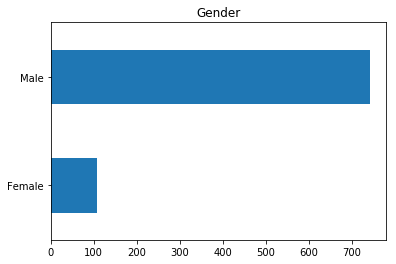

In [42]:
## Gender
_ = df['gender'].value_counts(ascending=True).plot(kind='barh', title='Gender')

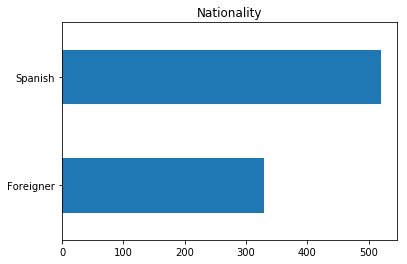

In [43]:
## Nationality
_ = df['nationality'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

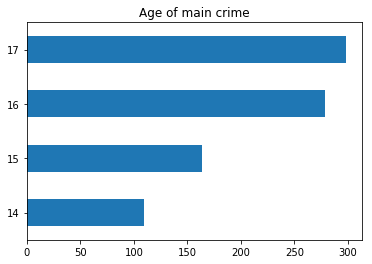

In [44]:
## Age when commiting the main crime
_ = df['main_crime_age'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

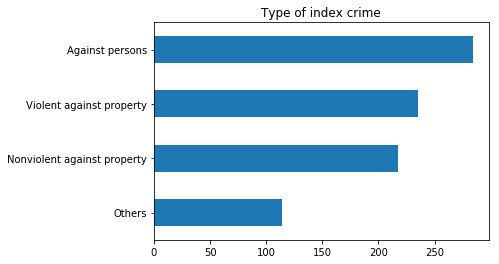

In [45]:
## Main crime category
_ = df['main_crime_category'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

### 2.3.7 Features that are more connected to recidivism

We use scikit-learn [Chi Squared test](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html). The p-values are interpreted as the strength of the feature, with smaller p-values indicating a better feature.

In [46]:
recidivism_details_columns = ["recidivism_number_offences", "recidividm_category_first_offence", "recidivism_violence_first_offence", "recidivism_severity"]

X = pd.get_dummies(df.drop(columns=["recidivism"] + recidivism_details_columns))
y = pd.get_dummies(df["recidivism"])["Yes"]

chisq, pval = chi2(X, y)

feature_chi2 = pd.Series(pval, X.columns.values)
feature_chi2.sort_values(0).head(10)

sum_all_risk_items                               2.364020e-48
sum_social_risk_items                            3.735096e-19
sum_individual_risk_items                        9.627105e-19
sum_historic_risk_items                          1.171836e-14
sum_all_protective_items                         2.648334e-12
criminal_records_More than 5 criminal records    2.994868e-10
professional_risk_evaluation_High                3.066945e-09
professional_risk_evaluation_Low                 2.545610e-07
risk11_delinquency_peer_group_Low                1.141544e-06
risk11_delinquency_peer_group_High               4.429592e-06
dtype: float64

### 2.3.8 Recidivism and human assessment

The column `professional_risk_evaluation` is an evaluation done by a professional expert, based on the results of SAVRY but applying his/her own judgment independently of the obtained score.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

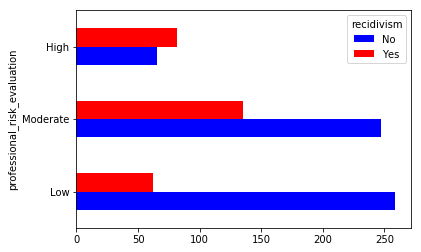

In [47]:
human_ctable = pd.crosstab(df.professional_risk_evaluation, df.recidivism)
human_ctable = human_ctable.reindex(index=["Low", "Moderate", "High"])
_ = human_ctable.plot(kind='barh', color=['blue', 'red'])

In [48]:
human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype=float)
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Yes"] / (row["Yes"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

recidivism,No,Yes,recidivism_rate
professional_risk_evaluation,,,
Low,259,62,0.193146
Moderate,247,135,0.353403
High,65,82,0.557823


### 2.3.9 Recidivism and overall score in structured assessment

The column `sum_all_risk_items` contains a sum of scores in the risk items of SAVRY.

In [49]:
scores_recidivists = df[df["recidivism"]=='Yes']["sum_all_risk_items"].values
scores_non_recidivists = df[df["recidivism"]=='No']["sum_all_risk_items"].values

In [50]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

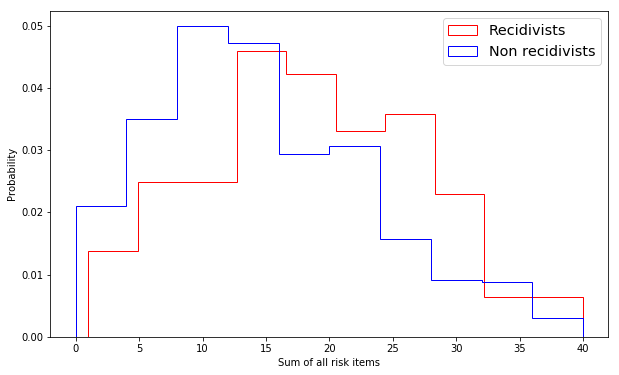

In [51]:
compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [52]:
def draw_roc_curve( ground_truth, predictions, pos_label="Yes"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

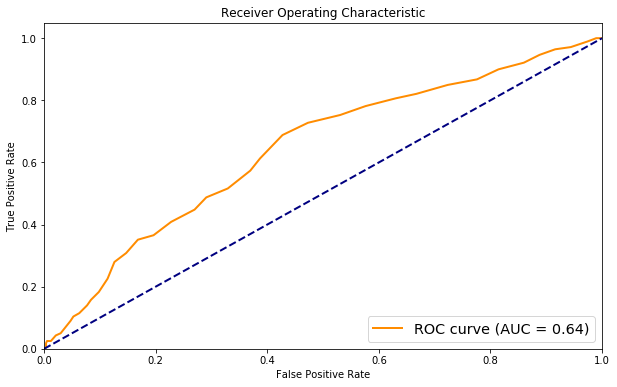

In [53]:
_ = draw_roc_curve(df["recidivism"].values, df["sum_all_risk_items"].values)

### 2.3.10 Modeling recidivism using logistic regression
Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [54]:
train, test = train_test_split(df, test_size=0.33)

**Modeling recidivism (24 risk factors)**

Now we model recidivism by using the 24 risk factors (attributes) in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [55]:
risk_factor_columns = ["risk01_previous_violence", "risk02_history_nonviolent_offences",
                       "risk03_early_violence_before_14", "risk04_past_intervention_fail",
                       "risk05_self_harm_suicide_attempts", "risk06_violence_at_home",
                       "risk07_childhood_mistreatment", "risk08_criminal_parent_caregiver",
                       "risk09_early_separation_parents", "risk10_poor_school_achievement", 
                       "risk11_delinquency_peer_group", "risk12_rejection_peer_group",
                       "risk13_poor_stress_coping", "risk14_poor_parental_skills_parents",
                       "risk15_lack_of_personal_social_support", "risk16_marginalized_environment",
                       "risk17_negative_attitudes", "risk18_risk_taker_impulsive",
                       "risk19_drug_abuse", "risk20_anger_management_issues",
                       "risk21_low_empaty", "risk22_attention_deficit",
                       "risk23_poor_compliance_interventions", "risk24_low_commitment_school"]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["recidivism"]

In [56]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [57]:
pred24_y = model.predict_proba(test_X)[:,1]

# Deprecated
#pred24_recidivists = pred24_y[test_y == 'Yes']
#pred24_non_recidivists = pred24_y[test_y == 'No']


pred24_recidivists=[]
pred24_non_recidivists=[]
for i in range(len(test_y)):
    if test_y.iloc[i] == 'Yes':
        pred24_recidivists.append(pred24_y[i])
    elif test_y.iloc[i] == 'No':
        pred24_non_recidivists.append(pred24_y[i])
    else:
        raise(pred24_y[i])

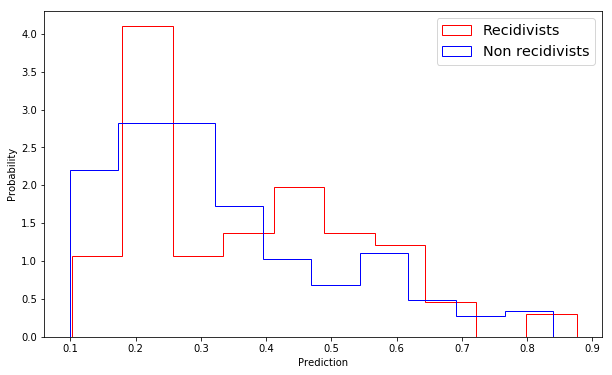

In [58]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

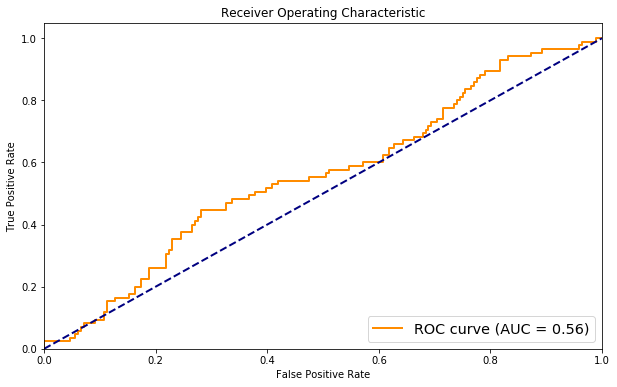

In [59]:
_ = draw_roc_curve(test_y, pred24_y)

**Modeling recidivism (personal history factors)**

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [60]:
demographic_columns = ["gender", "nationality", "main_crime_age", "criminal_records",
                       "main_crime_category", "main_crime_is_violent"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[demographic_columns])
test_y = test["recidivism"]

In [61]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [62]:
predPH_y = model.predict_proba(test_X)[:,1]


predPH_recidivists=[]
predPH_non_recidivists=[]
for i in range(len(test_y)):
    if test_y.iloc[i] == 'Yes':
        predPH_recidivists.append(predPH_y[i])
    elif test_y.iloc[i] == 'No':
        predPH_non_recidivists.append(predPH_y[i])
    else:
        raise(predPH_y[i])

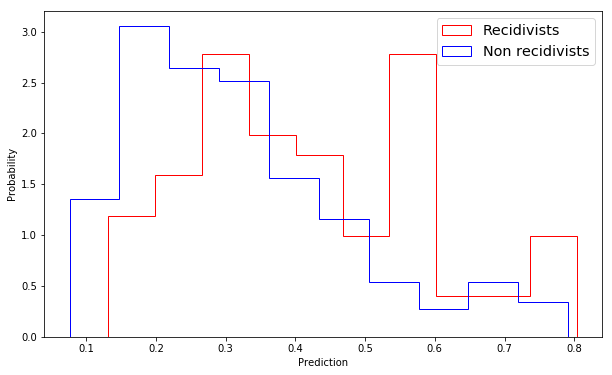

In [52]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

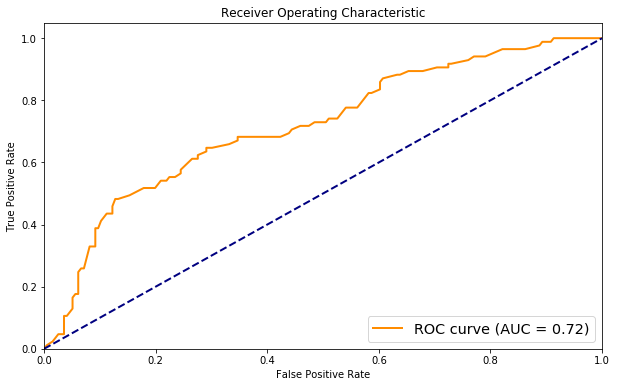

In [63]:
_ = draw_roc_curve(test_y, predPH_y)

**Modeling recidivism (personal history + 24 risk factors + 6 protective factors)**

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [64]:
protective_factor_columns = ["protective01_prosocial_activities", "protective02_strong_social_support",
                             "protective03_strong_link_prosocial_adult", "protective04_positive_attitude_interventions",
                             "protective05_high_commitment_school_or_work", "protective06_perseverant_personality"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism"]

In [65]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [66]:
predALL_y = model.predict_proba(test_X)[:,1]

# Deprecated
#predALL_recidivists = predALL_y[test_y == 'Yes']
#predALL_non_recidivists = predALL_y[test_y == 'No']

predALL_recidivists=[]
predALL_non_recidivists=[]
for i in range(len(test_y)):
    if test_y.iloc[i] == 'Yes':
        predALL_recidivists.append(predALL_y[i])
    elif test_y.iloc[i] == 'No':
        predALL_non_recidivists.append(predALL_y[i])
    else:
        raise(predALL_y[i])

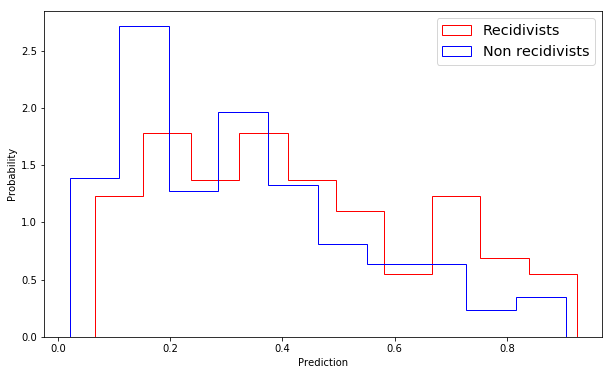

In [67]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

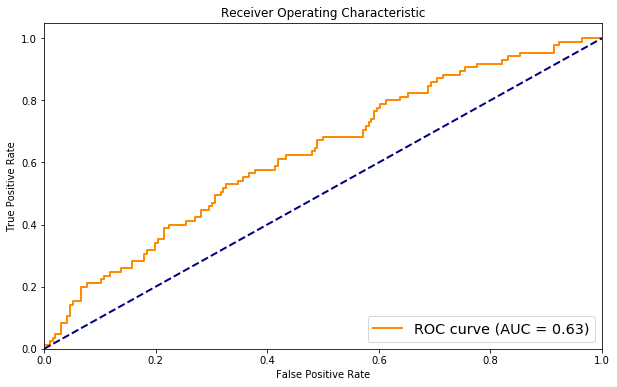

In [68]:
_ = draw_roc_curve(test_y, predALL_y)

### 2.3.11 Recidivism rates are different per sub-populations

We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a much higher rate than nationals.

In [69]:
recidivism_by_gender = pd.crosstab(df.recidivism, df.gender)
recidivism_by_gender

gender,Female,Male
recidivism,,
No,90,481
Yes,18,261


In [70]:
recidivism_by_gender['Female'] = recidivism_by_gender['Female'] / recidivism_by_gender['Female'].sum()
recidivism_by_gender['Male'] = recidivism_by_gender['Male'] / recidivism_by_gender['Male'].sum()
recidivism_by_gender

gender,Female,Male
recidivism,,
No,0.833333,0.648248
Yes,0.166667,0.351752


In [71]:
recidivism_by_nationality = pd.crosstab(df.recidivism, df.nationality)
recidivism_by_nationality

nationality,Foreigner,Spanish
recidivism,,
No,189,382
Yes,141,138


In [72]:
recidivism_by_nationality['Spanish'] = recidivism_by_nationality['Spanish'] / recidivism_by_nationality['Spanish'].sum()
recidivism_by_nationality['Foreigner'] = recidivism_by_nationality['Foreigner'] / recidivism_by_nationality['Foreigner'].sum()
recidivism_by_nationality

nationality,Foreigner,Spanish
recidivism,,
No,0.572727,0.734615
Yes,0.427273,0.265385


### 2.3.12 Fairness as equality of error rates

We look at fairness as **equality of error rates**, in this case false positive rates, following [Zafar et al. 2017](https://doi.org/10.1145/3038912.3052660) and [Hardt et al. 2016](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning).

###  Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [73]:
non_recidivists = df[df["recidivism"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists.professional_risk_evaluation, non_recidivists.gender)
non_recidivists_expert_by_gender.reindex(index=["Low", "Moderate", "High"])
non_recidivists_expert_by_gender

gender,Female,Male
professional_risk_evaluation,,
High,9,56
Low,44,215
Moderate,37,210


In [74]:
non_recidivists_expert_by_gender["Male"] = non_recidivists_expert_by_gender["Male"] / non_recidivists_expert_by_gender["Male"].sum()
non_recidivists_expert_by_gender["Female"] = non_recidivists_expert_by_gender["Female"] / non_recidivists_expert_by_gender["Female"].sum()
non_recidivists_expert_by_gender

gender,Female,Male
professional_risk_evaluation,,
High,0.100000,0.116424
Low,0.488889,0.446985
Moderate,0.411111,0.436590


In [75]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists.professional_risk_evaluation, non_recidivists.nationality)
non_recidivists_expert_by_nationality.reindex(index=["Low", "Moderate", "High"])
non_recidivists_expert_by_nationality

nationality,Foreigner,Spanish
professional_risk_evaluation,,
High,22,43
Low,88,171
Moderate,79,168


In [76]:
non_recidivists_expert_by_nationality["Spanish"] = non_recidivists_expert_by_nationality["Spanish"] / non_recidivists_expert_by_nationality["Spanish"].sum()
non_recidivists_expert_by_nationality["Foreigner"] = non_recidivists_expert_by_nationality["Foreigner"] / non_recidivists_expert_by_nationality["Foreigner"].sum()
non_recidivists_expert_by_nationality

nationality,Foreigner,Spanish
professional_risk_evaluation,,
High,0.116402,0.112565
Low,0.465608,0.447644
Moderate,0.417989,0.439791


### Overall SAVRY score and fairness

What we compute here is a sort of generalized false positive rate, i.e., the sumation of the scores for the people who ended up being negative (non-recidivist).


In [77]:
scores_nationals_non_recidivists = df[(df["recidivism"]=='No') &
                                      (df["nationality"]=='Spanish')]["sum_all_risk_items"].values
scores_foreigners_non_recidivists = df[(df["recidivism"]=='No') &
                                       (df["nationality"]=='Foreigner')]["sum_all_risk_items"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 14.29
Average SAVRY score of foreigner non-recidivist: 14.41


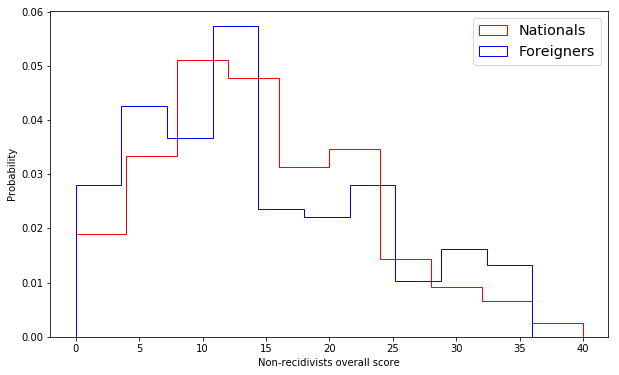

In [78]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="Nationals", label2="Foreigners")

### Fairness using ML score

In [79]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["nationality_Spanish"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["nationality_Foreigner"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.26
Average predicted probability of foreigner non-recidivist: 0.41


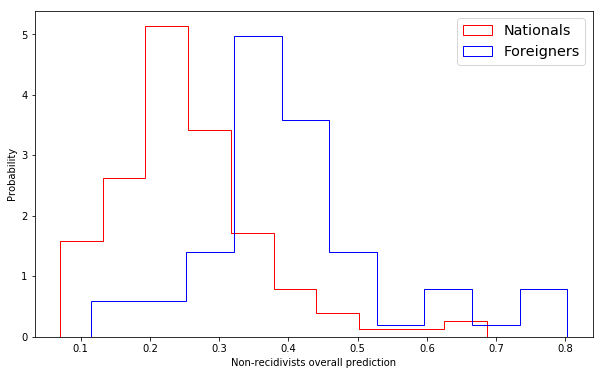

In [80]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

### Tasks to deliver (5 points):
<div class="alert alert-block alert-success">
    Try two of the following suggested activities:

<ul>
<li>A. Determine the relationship between human risk assessment (`professional_risk_evaluation`) and SAVRY total score (`sum_all_risk_items`).

* Plot the distribution of SAVRY total for cases where the human said low, medium, or high risk

</li>

<li>B. Consider the prediction of violent crimes only. SAVRY was designed to predict violence, not general recidivism.
<br>
* Consider that the person had violent recidivism if it committed either a crime against persons or a violent crime against property, otherwise, there was no violent recidivism.
</li>

<li>C. Study false negatives: people given low scores but that did recidivate.
    <br>
* Indicate what are the characteristics of this group of people that have false negatives.
</li>

<li>D. Find out if some offences are harder to predict than others
    <br>
* Try to create a predictive model specific to each type of offense.
</li>

<li>E. Try using the `recidivism_severity` variable as a target
    <br>
* This will be a multiclass problem, i.e., the target will not be binary.
</li>

<li>F. Try using cross-validation to have a better evaluation of the logistic regression classifier, or doing repeatedly random splits and averaging the results.
</li>

<li>G. Try other machine learning models such as SVM or neural networks.
</li>
                                                                                                                                                                 
</ul>                                                                         
                                                                                  
</div>

In [81]:
## Your code here for the first activity:

In [82]:
## Your code here for the second activity:

# Credits

The data file we use is a subset of data obtained by the *Centre d'Estudis Jurídics i Formació Especialitzada* of the Catalan government and released in 2017. Do not use this dataset for research, instead, use the [original dataset](http://cejfe.gencat.cat/en/recerca/cataleg/crono/2017/reincidencia-jj/) and cite the following publication:

```
@misc{cejfe_2017_savry,
 title={La reincid\`{e}ncia en la just\'{i}cia de menors},
 author={Marta Blanch and Manel Capdevila and Marta Ferrer and Berta Framis and \'{U}rsula Ruiz and Judit Mora and Ares Batlle and Berta L\'{o}pez},
 year={2017},
 howpublished={CEJFE},
 url={http://cejfe.gencat.cat/en/recerca/cataleg/crono/2017/reincidencia-jj/}
}
```

This Python Notebook is provided under a [Creative Commons License](https://creativecommons.org/licenses/by/4.0/).